## A demo of a "rich" sentiment analysis done in English

### Sentiment analysis

In [1]:
import numpy as np
import pandas as pd

import fasttext

We are using the CSV version of the IMDB dataset, which can be downloaded from Kaggle (https://www.kaggle.com/avnika22/imdb-perform-sentiment-analysis-with-scikit-learn/data).

We convert the sentiment labels from 0/1 to negative/positive to make the analysis more interpretable.

In [2]:
imdb_train = pd.read_csv("Datasets/IMDB/Train.csv")
imdb_test = pd.read_csv("Datasets/IMDB/Test.csv")

display(imdb_train.head(5))

imdb_train["label"].replace({0: "negative", 1: "positive"}, inplace=True)
imdb_test["label"].replace({0: "negative", 1: "positive"}, inplace=True)

display(imdb_train.head(5))

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


,text,label
0,I grew up (b. 1965) watching and loving the Th...,negative
1,"When I put this movie in my DVD player, and sa...",negative
2,Why do people who do not know what a particula...,negative
3,Even though I have great interest in Biblical ...,negative
4,Im a die hard Dads Army fan and nothing will e...,positive


For high resource languages like English, an accurate sentiment analysis can be achieved using transfomers-based models. For low resource languages however, we cannot assume the existence of pre-trained transfomers models like BERT and GPT. At the minimum, in an LRL case, we can resort to TF-IDF based features for sentiment analysis. But a quick look at the `fasttext` library (https://fasttext.cc/docs/en/crawl-vectors.html), we can see that pre-trained word embeddings exist for major SEA languages (e.g. Indonesian, Vietnamese, Thai etc.). We therefore are using it for this sentiment analysis demo. 

We use `fasttext` for both English and Indonesian sentiment analysis in our demos to highlight that even at this basic infrastructure level, we can still perform a richer sentiment analysis for English than for SEA langauges like Indonesian.  

The pretrained English `fasttext` embedding can be downloaded from https://fasttext.cc/docs/en/crawl-vectors.html, but its size is in GB. 

Feel free to just watch this demo during the workshop. In your own time, after the session, you can download the `fasttext` embedding to do the full hands-on yourself. 

Do ignore the warning message when loading the embedding.

In [3]:
ft = fasttext.load_model("Resources/cc.en.300.bin")

When using `fasttext`, one can get the vector representation of a paragraph or a sentence by calling the function `get_sentence_vector`. We use the `apply` function from `pandas` to convert all the paragraphs in the train and test sets into their respective embedding vector representations. 

In [4]:
imdb_train_df = pd.DataFrame.from_records(imdb_train.apply(lambda x: ft.get_sentence_vector(x["text"]), axis=1))
imdb_test_df = pd.DataFrame.from_records(imdb_test.apply(lambda x: ft.get_sentence_vector(x["text"]), axis=1))

In [5]:
display(imdb_train_df.head(3))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.001946,0.005286,-0.006489,0.032381,-0.018138,-0.006376,-0.000415,-0.007983,-0.003701,0.009630,...,0.019738,-0.000914,-0.053745,0.009884,-0.011864,0.001679,-0.000670,0.072408,-0.017808,-0.004818
1,-0.011655,0.006336,0.003707,0.052987,-0.024714,-0.013643,0.006096,-0.006864,-0.001421,0.001961,...,0.027027,-0.005935,-0.060790,0.001817,-0.008390,0.004865,0.004299,0.076055,-0.022863,-0.011334
2,-0.006900,0.000868,0.010029,0.051313,-0.039501,-0.019932,0.005248,-0.010559,-0.005026,0.000838,...,0.039897,0.000994,-0.062426,0.004365,-0.013127,0.005502,0.003938,0.078716,-0.009228,-0.004450


Now that we have the vector representation of the text dataset, we can perform a simple binary classification for sentiment analysis. We use `RandomForestClassifier` from `scikit-learn` in this demo. We can as well replace it with any other binary clasifier of out own choosing.   

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(imdb_train_df, imdb_train["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

After training, we can do prediction on the test set.

In [7]:
pred_sentiment = model.predict(imdb_test_df)

Get the accuracy and confusion matrix

In [8]:
from sklearn.metrics import classification_report

print(classification_report(pred_sentiment, imdb_test["label"]))

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81      2500
    positive       0.81      0.81      0.81      2500

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(imdb_test["label"], pred_sentiment)
cm_df = pd.DataFrame(cm, columns=[("True " + i) for i in np.unique(pred_sentiment)], index = [("Predicted " + i) for i in np.unique(pred_sentiment)])

display(cm_df)

,True negative,True positive
Predicted negative,2017,478
Predicted positive,483,2022


Test the model

In [10]:
sample_text = "The movie is so bad!!"
prediction = model.predict(ft.get_sentence_vector(sample_text).reshape(1, -1))
print(sample_text, prediction)

sample_text = "The movie is so nice."
prediction = model.predict(ft.get_sentence_vector(sample_text).reshape(1, -1))
print(sample_text, prediction)

The movie is so bad!! ['negative']
The movie is so nice. ['positive']


### Adding NER into the mix

In Engliish, we can go beyond a simple sentiment analysis as demonstrated up to this point. For example, we can filter the sentiment only for those reviews that make references to PERSON (e.g. because we care more about the reputations of some people, for example).  

The following shows how we can perform Named Entity Recognition (NER), to filter the sentiments on the reviews that mention any PERSON; while ignoring the rests. NER is not something that is not necessarily available for some SEA languages. 

We use a popular NER library for English, `spacy` (https://spacy.io/). Another alternative would be `stanza` (https://stanfordnlp.github.io/stanza/). But `spacy` is more optimised for industry use than `stanza` in general. 

If this is your first time using `spacy`, there is need to download the English model first by executing the command below in your environment in the command line:

`python -m spacy download en_core_web_sm`


In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")

We set up the `spacy` pipeline for NER below, and tag as `True` the IMDB reviews in the test set that contain any PERSON entity. 

In [13]:
imdb_include_person = []

nlp = spacy.load("en_core_web_sm")
for doc in nlp.pipe(imdb_test["text"], disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    imdb_include_person.append("PERSON" in [(ent.label_) for ent in doc.ents])

Show the first few reviews that make reference to a PERSON.

In [14]:
sample_reviews_w_person = [(x + " [" + pred_sentiment[i] + "]") for i,x in enumerate(imdb_test["text"]) if imdb_include_person[i]]
for i in sample_reviews_w_person[:5]:
    print(i + "\n")

I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lighthou

Show the first few reviews that DO NOT make reference to a PERSON.

In [15]:
sample_reviews_wo_person = [(x + " [" + pred_sentiment[i] + "]") for i,x in enumerate(imdb_test["text"]) if imdb_include_person[i]==False]
for i in sample_reviews_wo_person[:5]:
    print(i + "\n")

when i first read about "berlin am meer" i didn't expect much. but i thought with the right people, the right locations, the right music and fashion you could at least make a trivial movie about the hip berlin everyone seems to be talking about. but eissler failed, it's so ridiculously unauthentic. it's a complete misrepresentation of what it is going on in berlin's so called scene. of course it's not all about hippness, but you should expect more from a movie that's being sold as "the definite berlin movie".<br /><br />and apart from all the credibility stuff, it really is a bad movie. mediocre acting and a rather boring plot. interestingly some of the actors have proved in other movies that they are actually quite talented. so it really must be poor directing skills.<br /><br />don't bother watching "berlin am meer" unless you are 17, come from some small town in western Germany and want to move to the big city after you finished school. then you might actually find it enjoyable and 

Let's look at the sentiment distribution if we consider only those reviews that make any reference to a person. We can contrast it with the sentiment distribution of all the reviews in the test set. We can see that when a person is mentioned, the chance of a review being a positive one gets higher. 

,positive,negative
mentioning_a_person,2063,1853
all_reviews,2500,2500


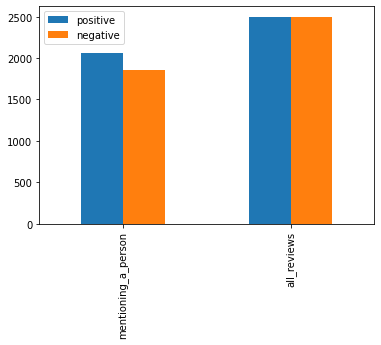

In [16]:
import matplotlib.pyplot as plt

x = pd.Series(pred_sentiment[np.where(imdb_include_person)]).value_counts()
y = pd.Series(pred_sentiment).value_counts()

z = pd.concat([x, y], axis=1)
z.columns =  ["mentioning_a_person", "all_reviews"]
z = z.transpose()

display(z)

z.plot.bar()
plt.show()

### Sentence-level analysis

Associating a mention of a person with the sentiment-tag at the review/paragraph level is very imprecise. There is a chance that a movie review is overall positive, but the sentiment of its mentioned director is actually negative. 

To make the association between a mentioned person and a sentiment value more precise, the sentiment analysis can be done at a sentence level. 

In the following we perform sentence segmentation of the IMDB reviews in the test data, and repeat the sentiment analysis and NER on the individual sentences. For efficiency sake, we only consider the first 100 reviews.

In [17]:
imdb_test_sentence = []
for i in imdb_test["text"][:100]:
    doc = nlp(i)
    for sent in doc.sents:
        imdb_test_sentence.append(sent.text)
        
temp = [print(i+"\n") for i in imdb_test_sentence[:10]]

I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily.

But then one day a tragic happenstance occurred.

After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow.

Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel.

But then why not just get up and walk across the country to watch TV in another state?

"

Nuts to that", I said.

So I decided to just hang tight on the couch and take whatever Fate had in store for me.

What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right!

This show is a total crud-pie!



In [18]:
imdb_sent_include_person = []

for doc in nlp.pipe(imdb_test_sentence, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    imdb_sent_include_person.append("PERSON" in [(ent.label_) for ent in doc.ents])

Show some example sentences that mention a person

In [19]:
temp = [print(x+"\n") for i,x in enumerate(imdb_test_sentence[:30]) if imdb_sent_include_person[i]==True]

I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily.

<br /><br />Except.. <br /><br />Except for the wonderful comic sty lings of Larry Joe Campbell, America's Greatest Comic Character Actor.

This guy plays Belushi's brother-in-law, Andy, and he is gold.

Without Larry Joe this show would consist of a slightly vacant looking Courtney Thorne-Smith smacking Belushi over the head with a frying pan while he alternately beats his chest and plays with the straw on the floor of his cage.

5 stars for Larry Joe Campbell designated Comedic Bacon because he improves the flavor of everything he's in!

1st watched 12/7/2002 - 3 out of 10(Dir-Steve Purcell): Typical Mary Kate & Ashley fare with a few more kisses.



Sentiment prediction at the sentence level

In [20]:
imdb_test_sent_df = pd.DataFrame.from_records([ft.get_sentence_vector(i) for i in imdb_test_sentence])
pred_sent_sentiment = model.predict(imdb_test_sent_df)

temp = [print(x+ " [" + pred_sent_sentiment[i] + "]\n") for i,x in enumerate(imdb_test_sentence[:50]) if imdb_sent_include_person[i]==True]

I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. [positive]

<br /><br />Except.. <br /><br />Except for the wonderful comic sty lings of Larry Joe Campbell, America's Greatest Comic Character Actor. [negative]

This guy plays Belushi's brother-in-law, Andy, and he is gold. [positive]

Without Larry Joe this show would consist of a slightly vacant looking Courtney Thorne-Smith smacking Belushi over the head with a frying pan while he alternately beats his chest and plays with the straw on the floor of his cage. [positive]

5 stars for Larry Joe Campbell designated Comedic Bacon because he improves the flavor of everything he's in! [negative]

1st watched 12/7/2002 - 3 out of 10(Dir-Steve Purcell): Typical Mary Kate & Ashley fare with a few more kisses. [negative]

Brenda Song is talented in comedy, but with this kind of movie, in some of the more serious scenes, her acting was laughable. [positive]

I think the worst thi

### Coreference resolution

If we rely only on NER to detect the presence of a mention of a person, we are missing out on many sentence that mentions a person through a coreference. For example, in the review below, the sentence "*But she's also shrill ...*" will be left out, even though it mentions Sandra Bernhard implicitly through a coreferencing pronoun "*she*". 

***

"*Film version of Sandra Bernhard's one-woman off-Broadway show is gaspingly pretentious. Sandra spoofs lounge acts and superstars, but her sense of irony is only fitfully interesting, and fitfully funny. Her fans will say she's scathingly honest, and that may be true. But she's also shrill, with an unapologetic, in-your-face bravado that isn't well-suited to a film in this genre. She doesn't want to make nice--and she's certainly not out to make friends--and that's always going to rub a lot of people the wrong way. But even if you meet her halfway, her material here is seriously lacking. Filmmaker Nicolas Roeg served as executive producer and, though not directed by him, the film does have his chilly, detached signature style all over it. Bernhard co-wrote the show with director John Boskovich; their oddest touch was in having all of Sandra's in-house audiences looking completely bored--a feeling many real viewers will most likely share. 1/2 from xxxx*"

***

To address this issue, we can perform an NLP technique called *Coreference Resolution* to indicate that the "*she*" in the sentence "*But she's also shrill ...*" is referring to Sandra Bernhard (who is a PERSON entity). This way, we will be able to include the sentence in the sentiment analysis. 

We do not include the code for the above coreference resolution analysis. However, we show below a figure that shows the result of applying coreference resolution on the above review, using AllenNLP demo (https://demo.allennlp.org/coreference-resolution).

![Coreference Resolution](Images/Coreference.png)

Coreference resolution model or dataset however is not readily available for SEA languages!

### Constituency parsing

To make the association between a person and a sentiment value more precise, we have moved from a review/paragraph-level analysis to a sentence-level analysis. However, we do not need to stop there. We can push it further to a clause-level analysis. This can be done using *Constituency Parsing*. For example, this sample sentence: *Sandra spoofs lounge acts and superstars, but her sense of irony is only fitfully interesting, and fitfully funny* can be broken down into multiple clauses by a constituency parser as shown below.

![Constituency Parsing](Images/Constituency.png)

We can perform sentiment analysis at the clause level, e.g. "*Sandra spoofs lounge acts and superstars* \[positive\]", "*her sense of irony is only fitfully interesting* \[negative\]" etc; connecting more precisely the sentiment values and the PERSON entities. 

Just like coreference resolution, models or datasets for constituency parsing are hard to find for SEA languages. 